<a href="https://colab.research.google.com/github/solayman-cs/ICH/blob/main/ICH_Combo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
%cd /content/drive/My Drive/DataSets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0

/content/drive/My Drive/DataSets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0


In [ ]:
diag_path = 'hemorrhage_diagnosis.csv'
df_diag = pd.read_csv(diag_path)
df_diag.shape

def swap_target(x):
    if x == 0:
        return 1
    else:
        return 0

# create a new target column
df_diag['Has_Hemorrhage'] = df_diag['No_Hemorrhage'].apply(swap_target)

# drop the old target column
df_diag = df_diag.drop('No_Hemorrhage', axis=1)

print(df_diag.shape)

# Create new columns


def get_mask_fname(row):
        
    mask_id = str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id
    

# create a new column with mask file names
df_diag['mask_fname'] = df_diag.apply(get_mask_fname, axis=1)




def new_mask_fname(row):
        
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id


# create a new column with a new mask file names
df_diag['new_mask_fname'] = df_diag.apply(new_mask_fname, axis=1)




def assign_image_fname(row):
    
    image_fname = str(row['SliceNumber']) + '.jpg'
    
    return image_fname


# create a new column with image file names
df_diag['image_fname'] = df_diag.apply(assign_image_fname, axis=1)



def assign_new_fname(row):
         
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '.jpg'
    
    return mask_id
    
# create a new column with new image file names
df_diag['new_image_fname'] = df_diag.apply(assign_new_fname, axis=1)



# Create new columns


def get_mask_fname(row):
        
    mask_id = str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id
    

# create a new column with mask file names
df_diag['mask_fname'] = df_diag.apply(get_mask_fname, axis=1)




def new_mask_fname(row):
        
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id


# create a new column with a new mask file names
df_diag['new_mask_fname'] = df_diag.apply(new_mask_fname, axis=1)




def assign_image_fname(row):
    
    image_fname = str(row['SliceNumber']) + '.jpg'
    
    return image_fname


# create a new column with image file names
df_diag['image_fname'] = df_diag.apply(assign_image_fname, axis=1)



def assign_new_fname(row):
         
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '.jpg'
    
    return mask_id
    
# create a new column with new image file names
df_diag['new_image_fname'] = df_diag.apply(assign_new_fname, axis=1)


NUM_TEST_IMAGES = 10


# get 10 images without hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 0]

df_no_hem = df.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
df_no_hem = df_no_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_no_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# get 10 images with hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 1]

df_with_hem = df.sample(NUM_TEST_IMAGES, random_state=102)

# Reset the index.
df_with_hem = df_with_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_with_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# create the test set
df_test = pd.concat([df_with_hem, df_no_hem], axis=0).reset_index(drop=True)
print(df_diag.shape)
print(df_test.shape)

# train_test_split


# shuffle
df_diag = shuffle(df_diag)

# reset the index
df_diag = df_diag.reset_index(drop=True)

# We will stratify by target
y = df_diag['Has_Hemorrhage']

df_train, df_val = train_test_split(df_diag, test_size=0.15, random_state=107, stratify=y)

df_diag.to_csv('df_data.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)

# Function to perform the augmentations

def augment_image_and_mask(augmentation, image, mask):
    
    """
 
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    3. mask - mask with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    Augmented mask as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image, mask=mask)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    mask_matrix = aug_image_dict['mask']
    
    return image_matrix, mask_matrix


# HOW TO DO MULTIPLE AUGMENTATIONS

# Define the augmentations

aug_types = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.OneOf([
        albu.RandomBrightnessContrast(),
        albu.RandomGamma(),
        albu.RandomBrightness(),
        ], p=0.3),
    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=0),
])    

IMAGE_HEIGHT_ORIG = 650
IMAGE_WIDTH_ORIG = 650

NUM_TEST_IMAGES = 10 # 10 with intracranial hem + 10 without intracranial hem

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3

BATCH_SIZE = 64


(2501, 9)
(2481, 13)
(20, 13)


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
# We are only using brain images for training.
# These are originally single channel images but cv2 will read them with 3 channels.

def train_generator_multiple(batch_size=64):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            lbl_list = list(df['Has_Hemorrhage'])
            
            train_labels = np.array(lbl_list)

            #train_labels = np.zeros(len(df), dtype=np.uint8)


            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            #Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]
                mask_id = mask_id_list[i]
                lbl = lbl_list[i]

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create Y_train
            # ===============
                
 

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
         
                
                
              
              
              
            # Augment the image and mask
            # ===========================
            
                #aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)
              
                # insert the image into X_train
                X_train[i] = image
                
                # insert the image into Y_train
                Y_train[i] = mask

                #train_labels[i] = lbl
                
                              
                
            # Normalize the images
            X_train = X_train/255
            Y_train = Y_train/255
            #labels = np.asarray(labels).astype('float32').reshape((-1,1))
            #labels = tf.one_hot(labels, depth=2)
            Y_train_batch = [Y_train, train_labels]
            

            yield X_train, Y_train_batch


def val_generator_multiple(batch_size=64):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            lbl_list = list(df['Has_Hemorrhage'])
            
            #val_labels = np.zeros(len(df), dtype=np.uint8)
            val_labels = np.array(lbl_list)
            
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

        
            
            # Create X_val
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_val[i] = image
                lbl = lbl_list[i]
            
            
            # Create Y_val
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_val[j] = mask
                #val_labels[j] = lbl
                
            
            # Normalize the images
            X_val = X_val/255
            Y_val = Y_val/255
            #val_labels = tf.one_hot(val_labels, depth=2)
            #val_labels = np.asarray(val_labels).astype('float32').reshape((-1,1))
            
           
            Y_val_batch = [Y_val, val_labels]
            print(val_labels.shape)

            yield X_val, Y_val_batch


def test_generator_multiple(batch_size=64):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_test.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])

            lbl_list = list(df['Has_Hemorrhage'])
            #print(lbl_list)

            test_labels = np.array(lbl_list)
            
            #test_labels = np.zeros(len(df), dtype=np.uint8)
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            #Y_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            Y_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)
            
            


            
            # Create X_test
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
           
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_test[i] = image
                lbl = lbl_list[i]
                
             
            # Create Y_test
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_test[j] = mask
                #test_labels[j] = lbl_list
            
            #test labels = lbl
            #tf.cast(Y_test, tf.float32)
            # Normalize the images
            X_test = X_test/255
            Y_test = Y_test/255

            Y_test_batch = [Y_test, test_labels]
            
            yield X_test, Y_test_batch


In [ ]:
# Test the generator

# initialize
train_gen_mul = train_generator_multiple(batch_size=64)

# run the generator
X_train, Y_train_batch = next(train_gen_mul)

print(X_train.shape)
print(Y_train_batch[0].shape)
print(Y_train_batch[1].shape)

# initialize
val_gen_mul = val_generator_multiple(batch_size=64)

# run the generator
X_val, Y_val_batch = next(val_gen_mul)

print(X_val.shape)
print(Y_val_batch[0].shape)
print(Y_val_batch[1].shape)


# initialize
test_gen_mul = test_generator_multiple(batch_size=64)

# run the generator
X_test, Y_test_batch = next(test_gen_mul)

print(X_test.shape)
print(Y_test_batch[0].shape)
print(Y_test_batch[1].shape)
print(Y_test_batch[1])


num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

(64, 256, 256, 3)
(64, 256, 256, 1)
(64,)
(64,)
(64, 256, 256, 3)
(64, 256, 256, 1)
(64,)
(20, 256, 256, 3)
(20, 256, 256, 1)
(20,)
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here

gen_train = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_train(X, y1, y2):
    geny1 = gen_train.flow(X,y1,  batch_size=batch_size,seed=666)
    geny2 = gen_train.flow(X,y2, batch_size=batch_size,seed=666)
    while True:
            y1i = geny1.next()
            y2i = geny2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield y1i[0], [y1i[1], y2i[1]]


# initialize
train_gen = train_generator_multiple(batch_size=64)

# run the generator
X_train, Y_train_batch = next(train_gen)


# Finally create generator
gen_flow_trn = gen_flow_train(X_train, Y_train_batch[0], Y_train_batch[1])

print(Y_train_batch[1])
print(len(Y_train_batch[1]))           

[0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0]
64


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen_val = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_val(X, y1, y2):
    geny1 = gen_val.flow(X,y1,  batch_size=batch_size,seed=666)
    geny2 = gen_val.flow(X,y2, batch_size=batch_size,seed=666)
    while True:
            y1i = geny1.next()
            y2i = geny2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            #yield [y1i[0], y1i[1]], [y2i[0], y2i[1]]
            yield y1i[0], [y1i[1], y2i[1]]

# initialize
val_gen = val_generator_multiple(batch_size=64)

# run the generator
X_val, Y_val_batch = next(val_gen)


# Finally create generator
gen_flow_vl = gen_flow_val(X_val, Y_val_batch[0], Y_val_batch[1])

print(Y_val_batch[1])
print(len(Y_train_batch[1]))

(64,)
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
64


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen_test = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_test(X, y1, y2):
    geny1 = gen_val.flow(X,y1,  batch_size=batch_size,seed=666)
    geny2 = gen_val.flow(X,y2, batch_size=batch_size,seed=666)
    while True:
            y1i = geny1.next()
            y2i = geny2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            #yield [y1i[0], y1i[1]], [y2i[0], y2i[1]]
            yield y1i[0], [y1i[1], y2i[1]]

# initialize
test_gen = test_generator_multiple(batch_size=64)

# run the generator
X_test, Y_test_batch = next(test_gen)


# Finally create generator
gen_flow_tst = gen_flow_test(X_test, Y_test_batch[0], Y_test_batch[1])

print(Y_test_batch[1])
print(len(Y_test_batch[1]))
print(type(Y_test_batch[1]))
print(Y_test_batch[1].shape)

[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
20
<class 'numpy.ndarray'>
(20,)


In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.4 MB/s 


In [ ]:
!pip install keras-unet-collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 3.1 MB/s 


In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)

import tensorflow as tf

from tensorflow.keras.optimizers import Adam

from keras.losses import binary_crossentropy

from keras.initializers import he_normal
from keras import backend as K

import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models import  get_preprocessing # this line has an error in the docs

from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from segmentation_models.losses import dice_loss
#from segmentation_models.metrics import dice_score

from segmentation_models.utils import set_trainable
from keras_unet_collection import models, utils

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
model_attn = models.att_unet_2d((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), filter_num=[64, 128, 256, 512, 1024], n_labels=2, 
                           stack_num_down=2, stack_num_up=2, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='attunet')

/usr/local/lib/python3.7/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model_attn.summary()

Model: "attunet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 EfficientNetB0_backbone (Funct  [(None, 128, 128, 9  945927     ['input_8[0][0]']                
 ional)                         6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 240                                   

In [ ]:
for index, layer in enumerate(model_attn.layers):
    print(index, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7f73203f7110>
1 <keras.engine.functional.Functional object at 0x7f73217d64d0>
2 <keras.layers.convolutional.Conv2DTranspose object at 0x7f731cdab250>
3 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f731cdaec50>
4 <keras.layers.advanced_activations.ReLU object at 0x7f731d600210>
5 <keras.layers.convolutional.Conv2D object at 0x7f731c0b2650>
6 <keras.layers.convolutional.Conv2D object at 0x7f731cdc5a10>
7 <keras.layers.merge.Add object at 0x7f731cd5b750>
8 <keras.layers.advanced_activations.ReLU object at 0x7f731cd4ea90>
9 <keras.layers.convolutional.Conv2D object at 0x7f731cdbf8d0>
10 <keras.layers.core.activation.Activation object at 0x7f731cd5b350>
11 <keras.layers.merge.Multiply object at 0x7f731cd56310>
12 <keras.layers.merge.Concatenate object at 0x7f731cd8b890>
13 <keras.layers.convolutional.Conv2D object at 0x7f731cd6f250>
14 <keras.layers.normalization.batch_normalization.BatchNormalization obje

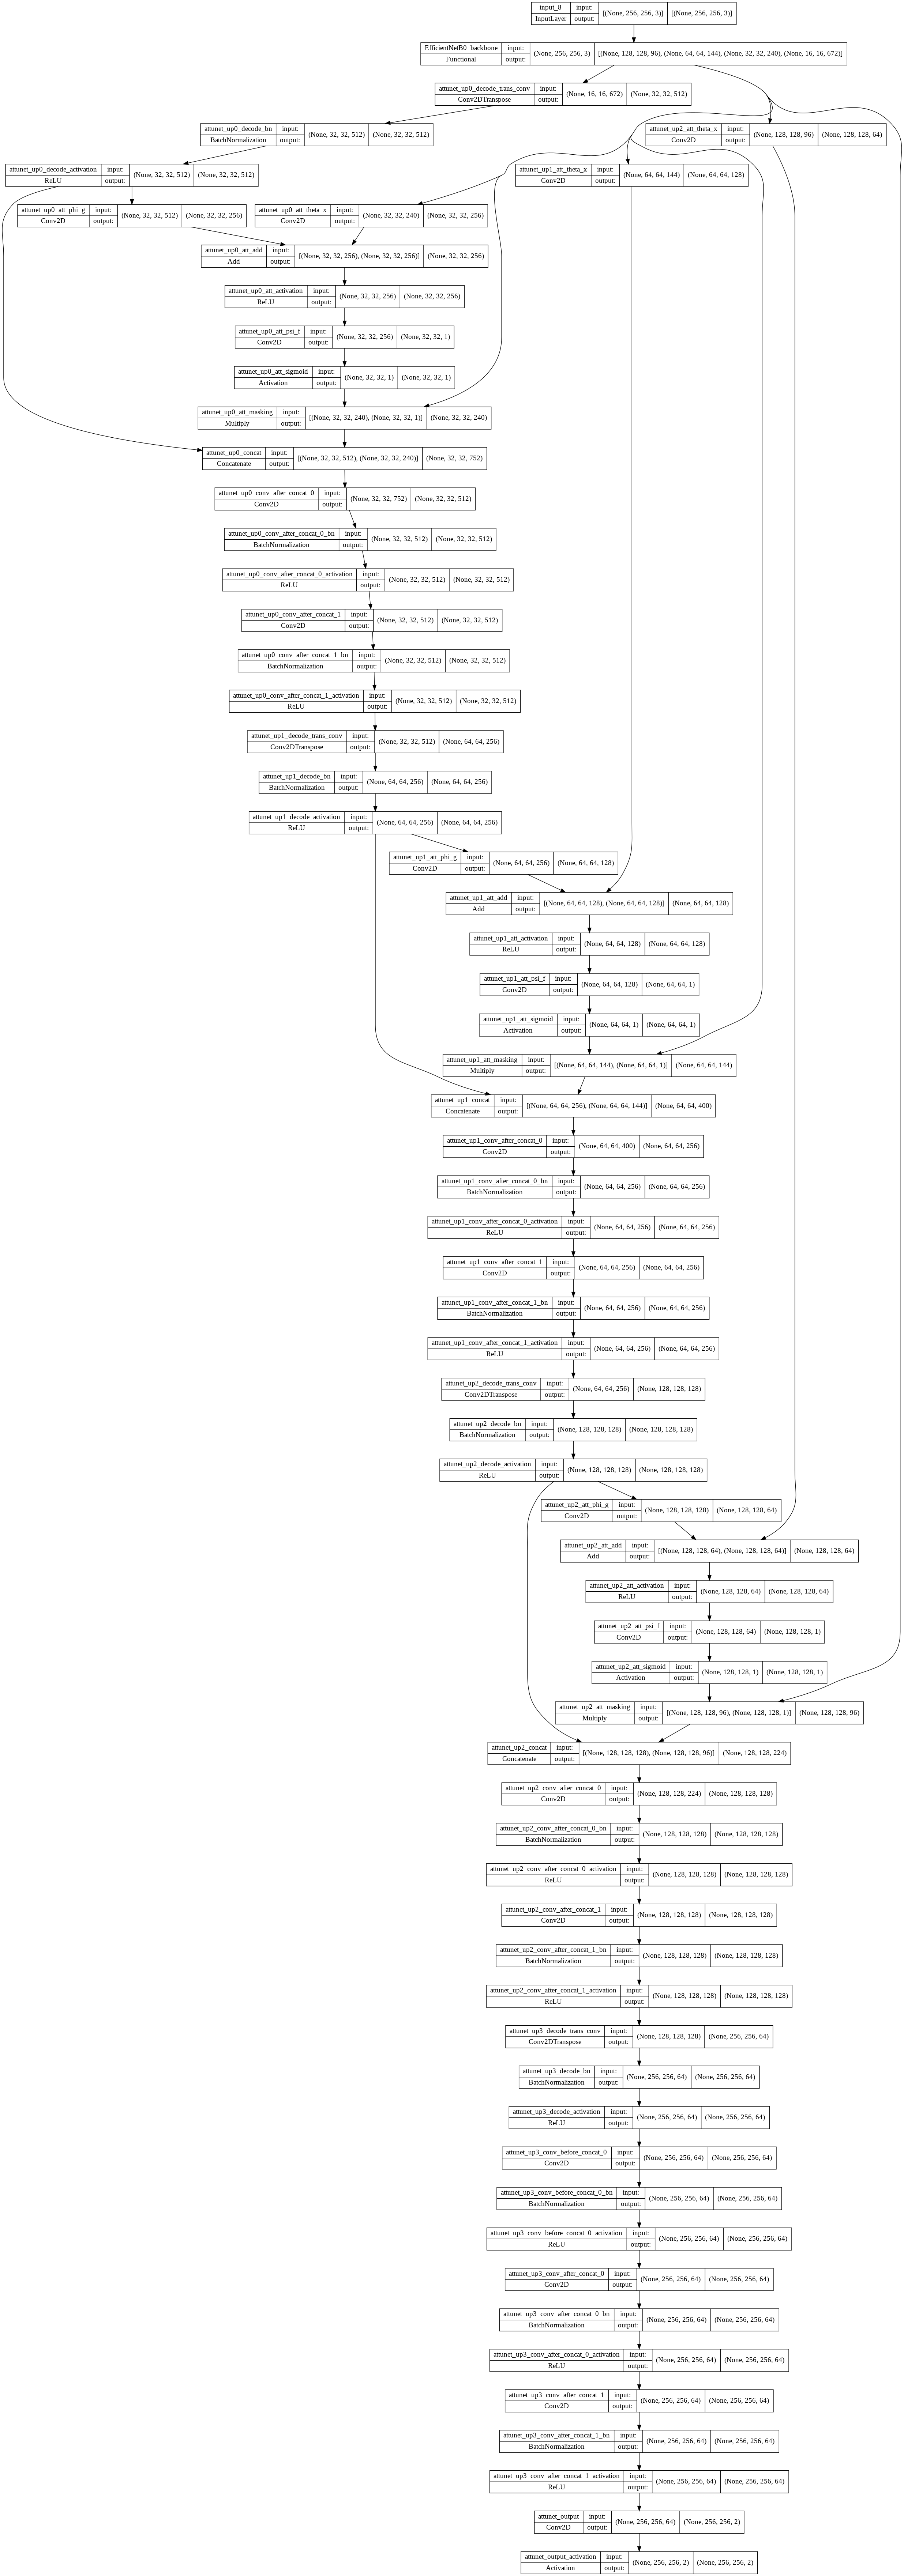

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model_attn, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
# Segmentation and Binary Classification
# Encoder: mobilenetv2 
# Decoder: Unet


from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)


BACKBONE = 'efficientnetb0'
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
'''model = Unet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
             #freeze_encoder=False,
             classes=1, 
             encoder_weights='imagenet',
             activation='sigmoid')'''

cls_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

#inpt = model.layers[266].output
#print(model_attn.layers[197].output.shape)
print(model_attn.output.shape)

# classif path
x = GlobalAveragePooling2D()(model_attn.layers[36].output)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
#x = Flatten()(x)
x = Dropout(0.5)(x)
classification = Dense(1, activation='sigmoid', name='classification')(x)
print(classification.shape)


my_model = Model(inputs=model_attn.input, outputs= [model_attn.output, classification])



my_model.summary()

(None, 256, 256, 2)
(None, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16_backbone (Functional)    [(None, 256, 256, 6  14714688    ['input_1[0][0]']                
                                4),                                                               
                                 (None, 128, 128, 1                                               
                                28),                                                              
                                 (None, 64, 64, 256             

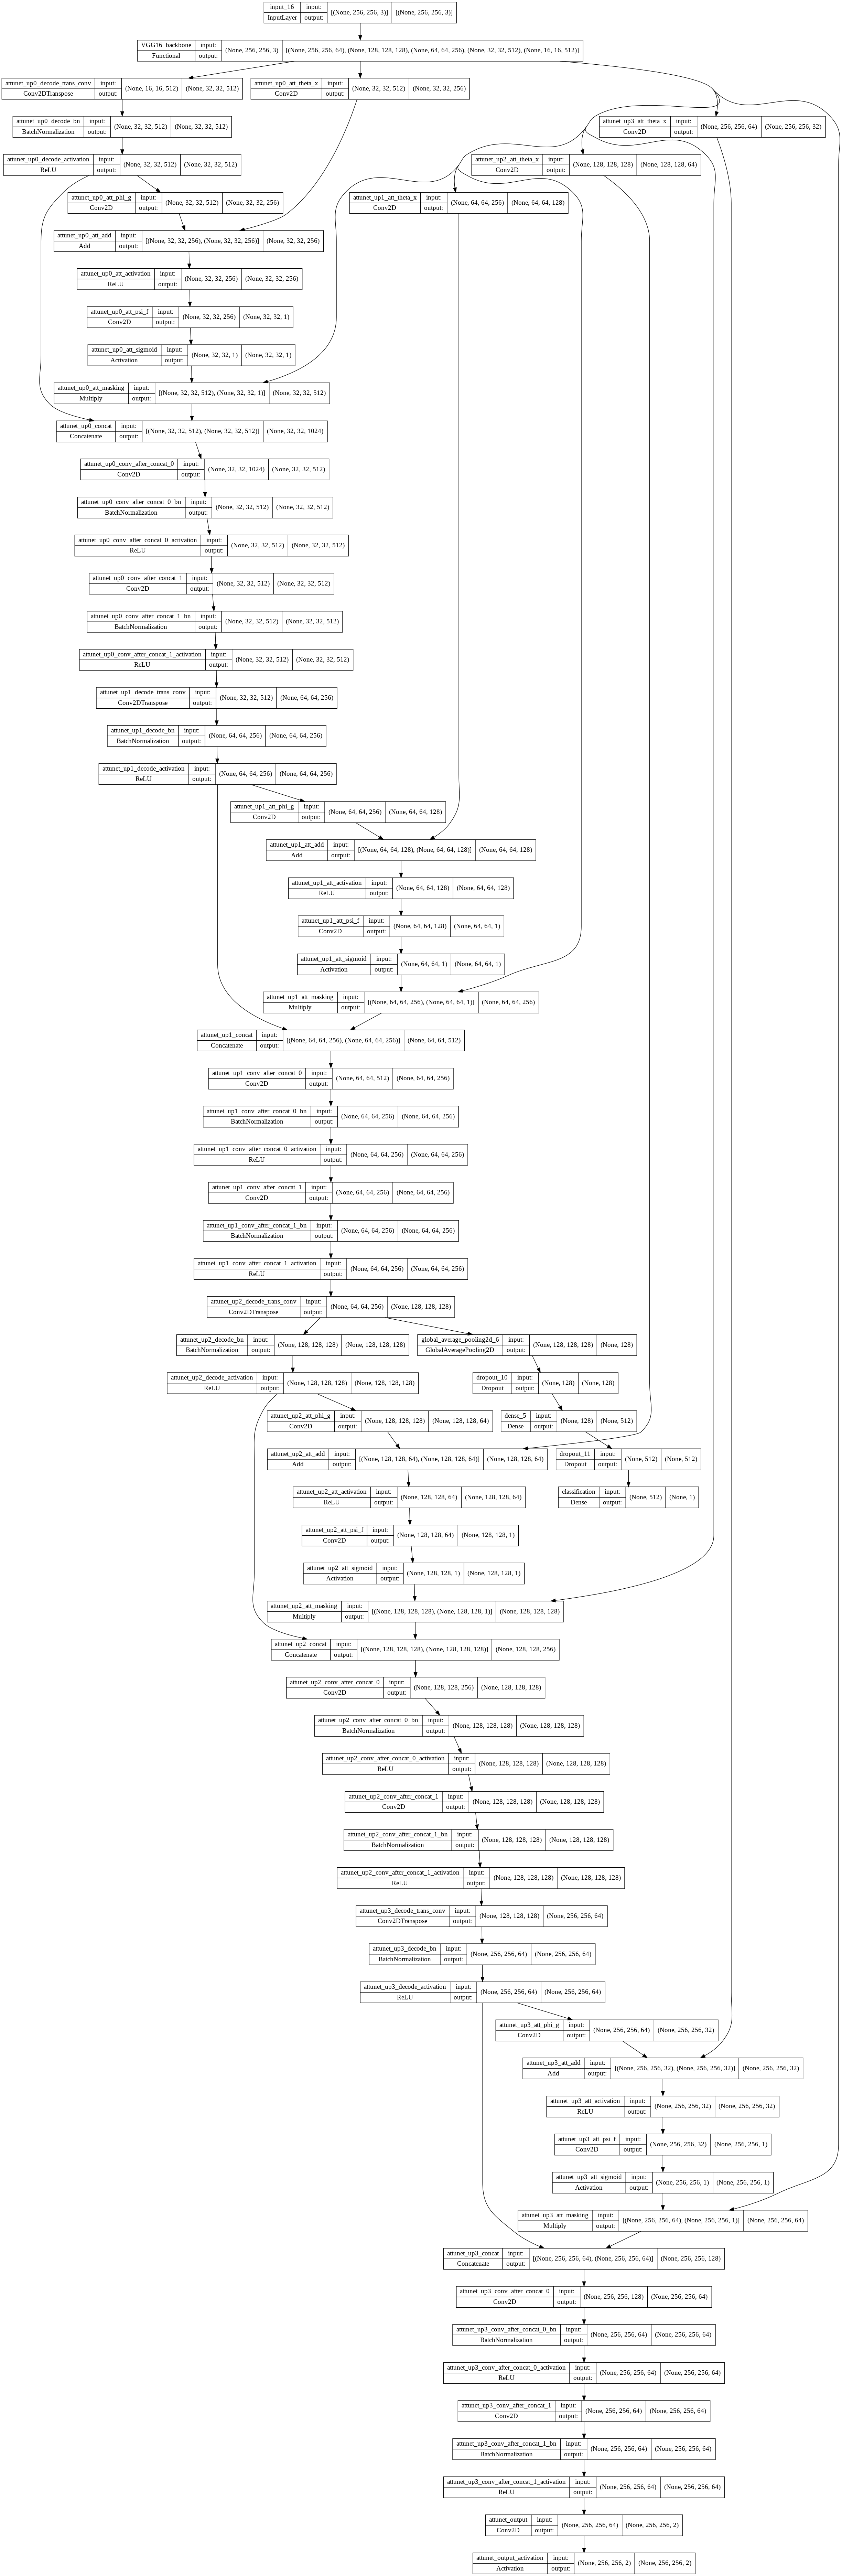

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(my_model, to_file='my_model.png', show_shapes=True,show_layer_names=True)
Image(filename='my_model.png')

In [ ]:
# Specify the optimizer, and compile the model with loss functions for both outputs

# optimizer1 = tf.train.AdamOptimizer().minimize(loss1)
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer2 = tf.keras.optimizers.SGD(learning_rate=0.001)

HEAD1_WEIGHT = 0.55
HEAD2_WEIGHT = 0.45

my_model.compile(
    #optimizer={'attunet_output_activation': optimizer1, 'classification': optimizer2},
    optimizer = optimizer1,
    loss={'attunet_output_activation': dice_loss, 'classification': 'binary_crossentropy'},
    loss_weights={"attunet_output_activation": HEAD1_WEIGHT, "classification": HEAD2_WEIGHT},
    metrics={'attunet_output_activation': iou_score, 'classification': 'accuracy'}
    )



'''my_model.compile(
    optimizer=optimizer,
    loss={'sigmoid': dice_loss, 'classif_output': 'binary_crossentropy'},
    metrics={'sigmoid': iou_score, 'classif_output': 'accuracy'}
    )'''

'''my_model.compile(
    Adam(learning_rate=0.0001),
    loss=[dice_loss],
    metrics=[iou_score, 'accuracy'],
)'''



filepath = "model_combo.h5"

earlystopper = EarlyStopping(patience=15, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_attunet_output_activation_iou_score', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_attunet_output_activation_iou_score', factor=0.5, patience=2, 
                                   verbose=1, mode='max')



log_fname = 'training_log_combo.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, earlystopper, csv_logger, reduce_lr]

history = my_model.fit(X_train, [Y_train_batch[0], Y_train_batch[1]], steps_per_epoch=train_steps, epochs=100, 
                              validation_data=(X_val, [Y_val_batch[0], Y_val_batch[1]]), validation_steps=val_steps,
                             verbose=1, callbacks=callbacks_list)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.8574 - attunet_output_activation_loss: 0.9850 - classification_loss: 0.7015 - attunet_output_activation_iou_score: 0.0080 - classification_accuracy: 0.8485 
Epoch 1: val_attunet_output_activation_iou_score improved from -inf to 0.00271, saving model to model_combo.h5
33/33 [==============================] - 525s 16s/step - loss: 0.8574 - attunet_output_activation_loss: 0.9850 - classification_loss: 0.7015 - attunet_output_activation_iou_score: 0.0080 - classification_accuracy: 0.8485 - val_loss: 0.6281 - val_attunet_output_activation_loss: 0.9945 - val_classification_loss: 0.1802 - val_attunet_output_activation_iou_score: 0.0027 - val_classification_accuracy: 0.9219 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.7429 - attunet_output_activation_loss: 0.9831 - classification_loss: 0.4492 - attunet_output_activation_iou_score: 0.0093 - classification_accuracy: 0.8182 
Epoch 2: val_

KeyboardInterrupt: ignored

In [ ]:
# Make a prediction

# initialize the test generator
test_gen = test_generator_multiple(batch_size=64)

my_model.load_weights('model_combo.h5')
predictions = my_model.predict(test_gen, 
                                      steps=len(df_test),  
                                      verbose=1)

20/20 [==============================] - 816s 41s/step


In [ ]:
print(type(predictions))

<class 'list'>


In [ ]:
print(predictions)

[array([[[[1.74847245e-03, 1.84327364e-04],
         [2.65657902e-04, 6.45298496e-06],
         [3.13758850e-04, 1.46446100e-05],
         ...,
         [3.00347805e-04, 1.46904349e-05],
         [2.78294086e-04, 1.11199079e-05],
         [7.08132982e-04, 3.65168016e-05]],

        [[6.86168671e-04, 1.09070919e-04],
         [7.36133225e-05, 4.20026709e-06],
         [1.54495239e-04, 2.23714596e-05],
         ...,
         [1.52975321e-04, 2.28346817e-05],
         [1.30563974e-04, 1.53400451e-05],
         [9.48929519e-05, 9.64893388e-06]],

        [[5.96225262e-04, 7.75939043e-05],
         [7.75654189e-05, 4.92318577e-06],
         [2.59071589e-04, 5.18175511e-05],
         ...,
         [3.01748514e-04, 6.54068936e-05],
         [2.20447779e-04, 3.76229727e-05],
         [1.57415867e-04, 1.62451743e-05]],

        ...,

        [[5.20169735e-04, 6.83374892e-05],
         [8.14919258e-05, 5.65890514e-06],
         [2.56061554e-04, 6.75202755e-05],
         ...,
         [3.07530165

In [ ]:
print(predictions[0].shape)
print(type(predictions[0]))

(400, 256, 256, 2)
<class 'numpy.ndarray'>


In [ ]:
preds_test_thresh = (predictions[0] >= 0.7).astype(np.uint8)

preds_test_thresh.shape

print(preds_test_thresh.min())
print(preds_test_thresh.max())

0
1


In [ ]:
indx = 7

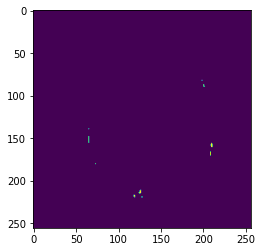

In [ ]:
# This is a predicted mask

pred_mask = preds_test_thresh[indx,:,:,0]
plt.imshow(pred_mask)

In [ ]:
print(predictions[1][indx])

[0.4505507]


In [ ]:
print(len(predictions[1]))

400


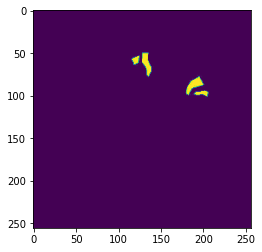

In [ ]:
# This is a true mask

true_mask = Y_test_batch[0][indx,:,:,0]
plt.imshow(true_mask)

In [ ]:
print(Y_test_batch[1][indx])

1


In [ ]:
def dice_img(y_true, y_pred):
    dice=0
    counter = 0
    for i in range(y_true.shape[0]):
        if np.sum(y_true[i]) > 0:  # Considering only the slices that have hemorrhage regions,
            dice += dice_fun(y_true[i], y_pred[i])
            counter += 1
    if counter>0:
        return dice/counter
    else:
        return np.nan

def dice_fun(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [ ]:
print(dice_img(true_mask, pred_mask))

0.09772760163370064


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [ ]:
dice_sm = []
y = 10
for indx in range(y):
  pred_mask = preds_test_thresh[indx,:,:,0]
  true_mask = Y_test_batch[0][indx,:,:,0]
  r = dice_img(pred_mask, true_mask)
  dice_sm.append(r)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [ ]:
print ("Dice Similarity: {}".format(dice_sm))

Dice Similarity: [0.0, 0.0, 0.019106884722648272, 0.0, 0.39781613905979957, 0.0, 0.0662794963678708, 0.0, 0.13795821462488134, 0.12022046232717142]


In [ ]:
dc = np.array(dice_sm)

In [ ]:
np.nanmean(dc)

0.07413811971023714